In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mast.mast_client import ListType
import pyuda
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sys, os

lp_module_path = '/home/cl6305/Documents/data_access/mastu_exhaust_analysis/mastu_exhaust_analysis'
if lp_module_path not in sys.path:
    sys.path.append(lp_module_path)

from mastu_exhaust_analysis.pyLangmuirProbe import LangmuirProbe, compare_shots, probe_array

notebook_functions_path = '/home/cl6305/Documents/data_access/notebooks/plasma_control/diagnostic_analysis/'
if notebook_functions_path not in sys.path:
    sys.path.append(notebook_functions_path)

from custom_diagnostic_functions import *
import pyuda
client=pyuda.Client()
import matplotlib.pyplot as plt
import numpy as np


"""Plotting settings"""
plt.style.use('seaborn')
plt.rcParams.update({'font.size': 10})
linewidth = 3
markersize = 15


plt.style.use('ggplot')
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams.update({'font.size': 14})

shot_number = 49259
# shot_number = 49220
shot_number = 49213
# shot_number = 49259
# shot_number = 49260
# shot_number = 49212

shot_number = 45470


shot_number =  45416

In [2]:
def sxd_calibration(shot_number, cal_fac = None):

    d_alpha_sxd, d_alpha_sxd_time = d_alpha_divertor_asymmetry(shot_number, 'SXD', output_time=True, calibrate = cal_fac)
    d_alpha_sxd_upper_sig, d_alpha_sxd_lower_sig, d_alpha_sig_time = d_alpha_signal(shot_number, 'SXD', output_time=True, calibrate = cal_fac)
    mag_z, mag_time = magnetic_axis_zc(shot_number, output_time=True, trim=True)

    fig,ax = plt.subplots(2,1, figsize = (20,12), sharex= True)
    axes12 = ax[0].twinx()

    ax[0].plot(d_alpha_sxd_time, d_alpha_sxd, label = 'd_alpha_sxd_assymmetry')

    axes12.plot(mag_time, mag_z, label = 'mag_z', color = 'black')
    axes12.grid(False)


    ax[1].plot(d_alpha_sig_time, d_alpha_sxd_upper_sig, label = 'd_alpha_sxd_upper_sig')
    ax[1].plot(d_alpha_sig_time, d_alpha_sxd_lower_sig, label = 'd_alpha_sxd_lower_sig')

    for axesx in ax:
        axesx.set_xbound(0,1)
        axesx.legend()

/home/cl6305/Documents/data_access/notebooks/plasma_control/diagnostic_analysis/custom_diagnostic_functions.py:100: RuntimeWarning: invalid value encountered in true_divide
  asymmetry = (upper_signal - lower_signal) / (upper_signal + lower_signal)


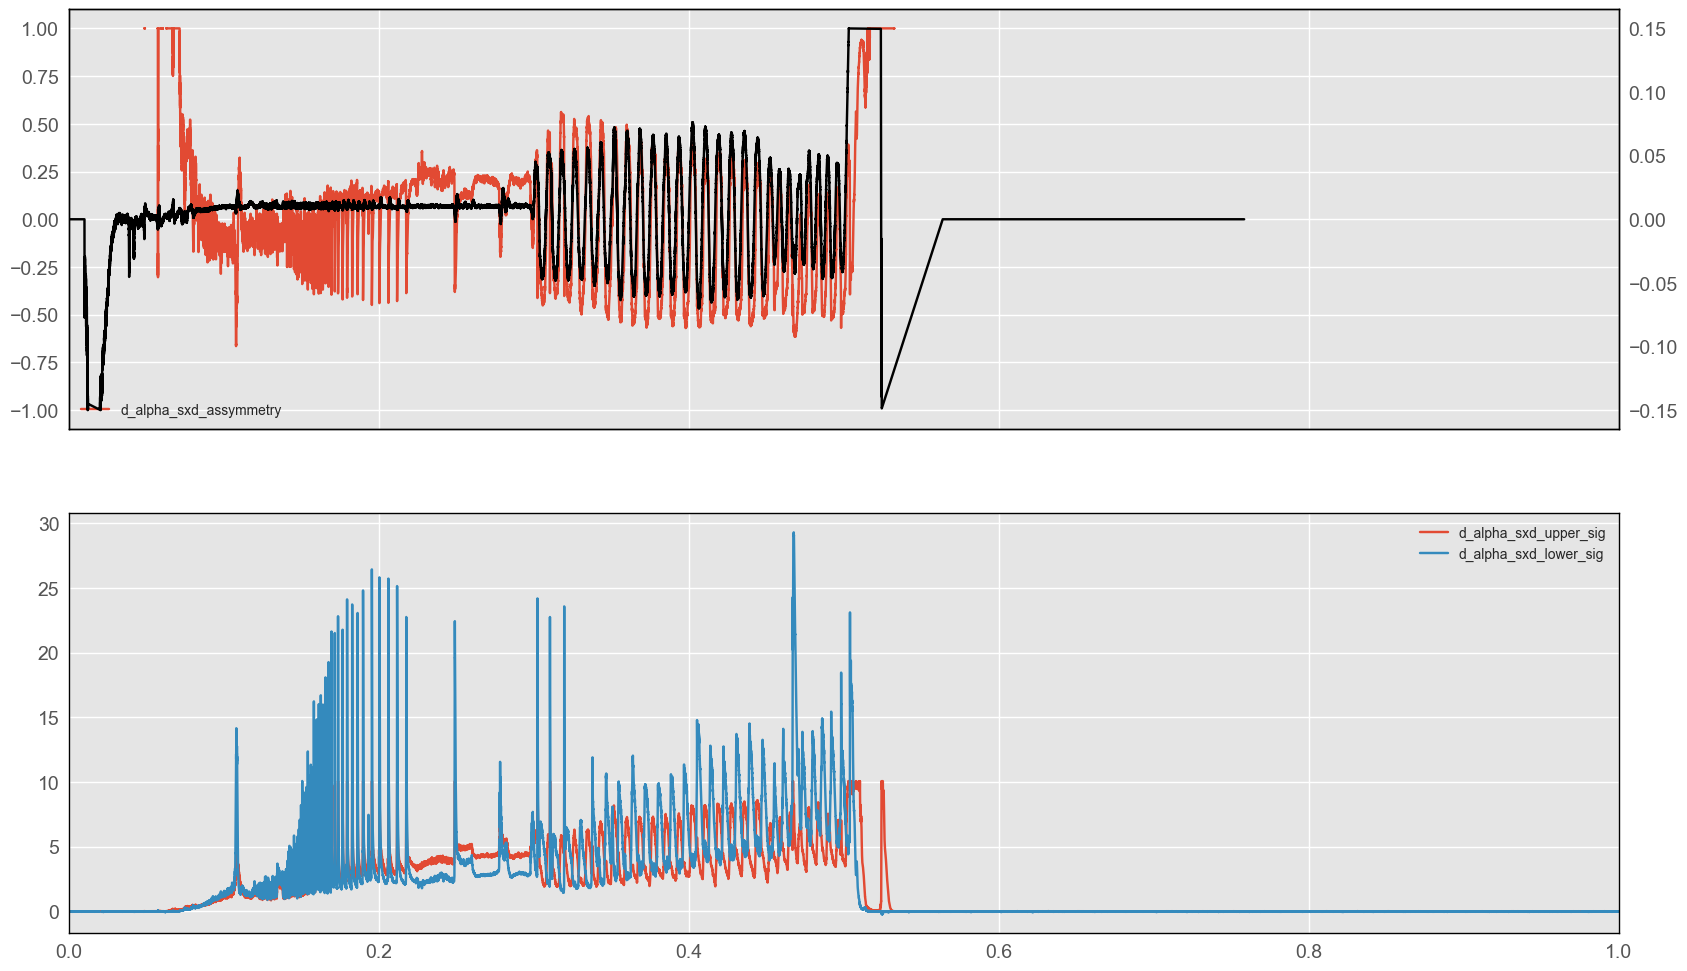

In [3]:
shot_number = 49261
cal_fac = 4.5

sxd_calibration(shot_number, cal_fac = cal_fac)

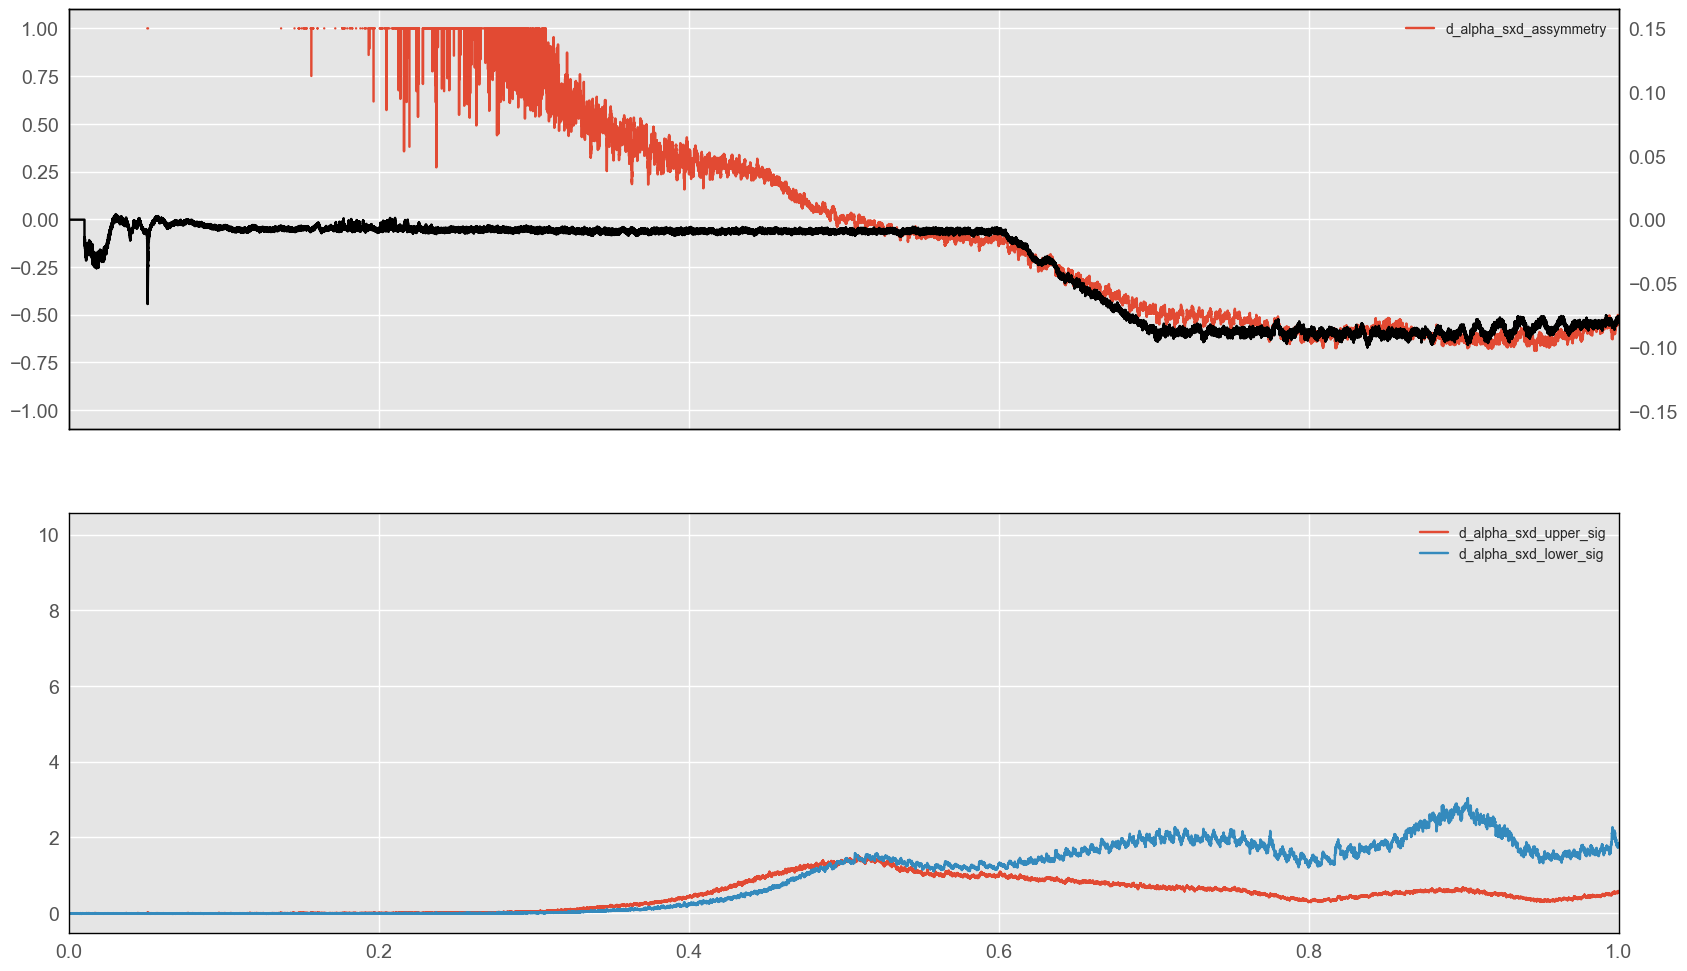

In [4]:
shot_number = 45416
cal_fac = 1.5

sxd_calibration(shot_number, cal_fac = cal_fac)




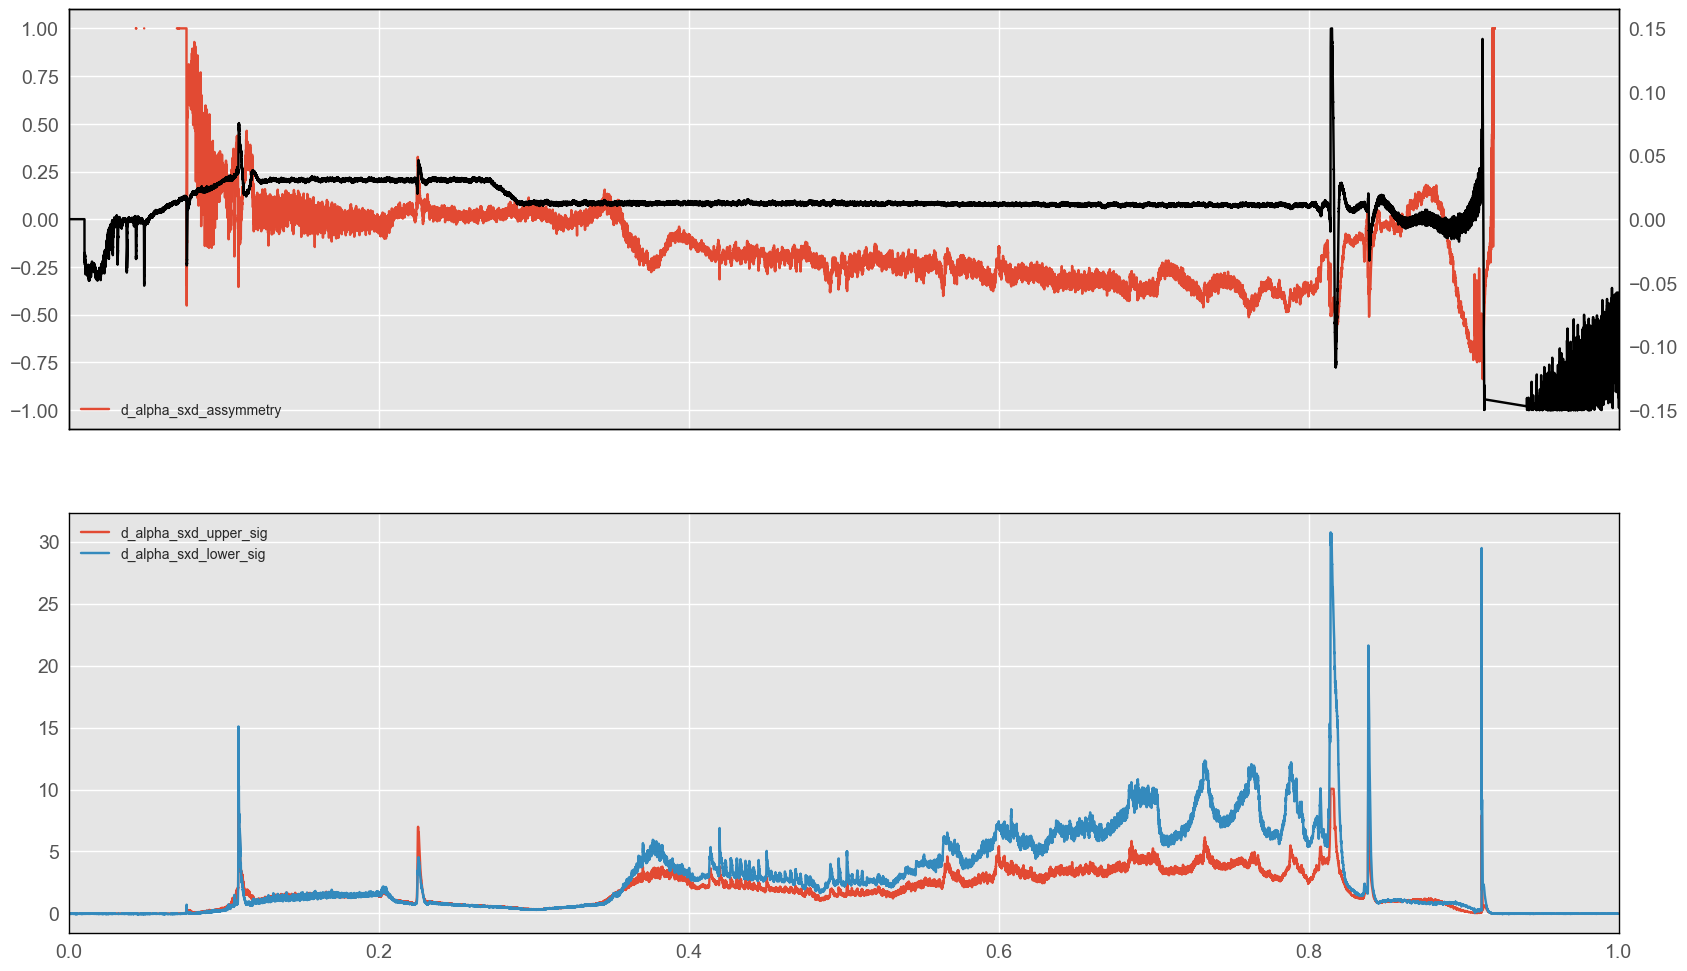

In [5]:
shot_number = 45460

cal_fac = 4


sxd_calibration(shot_number, cal_fac = cal_fac)

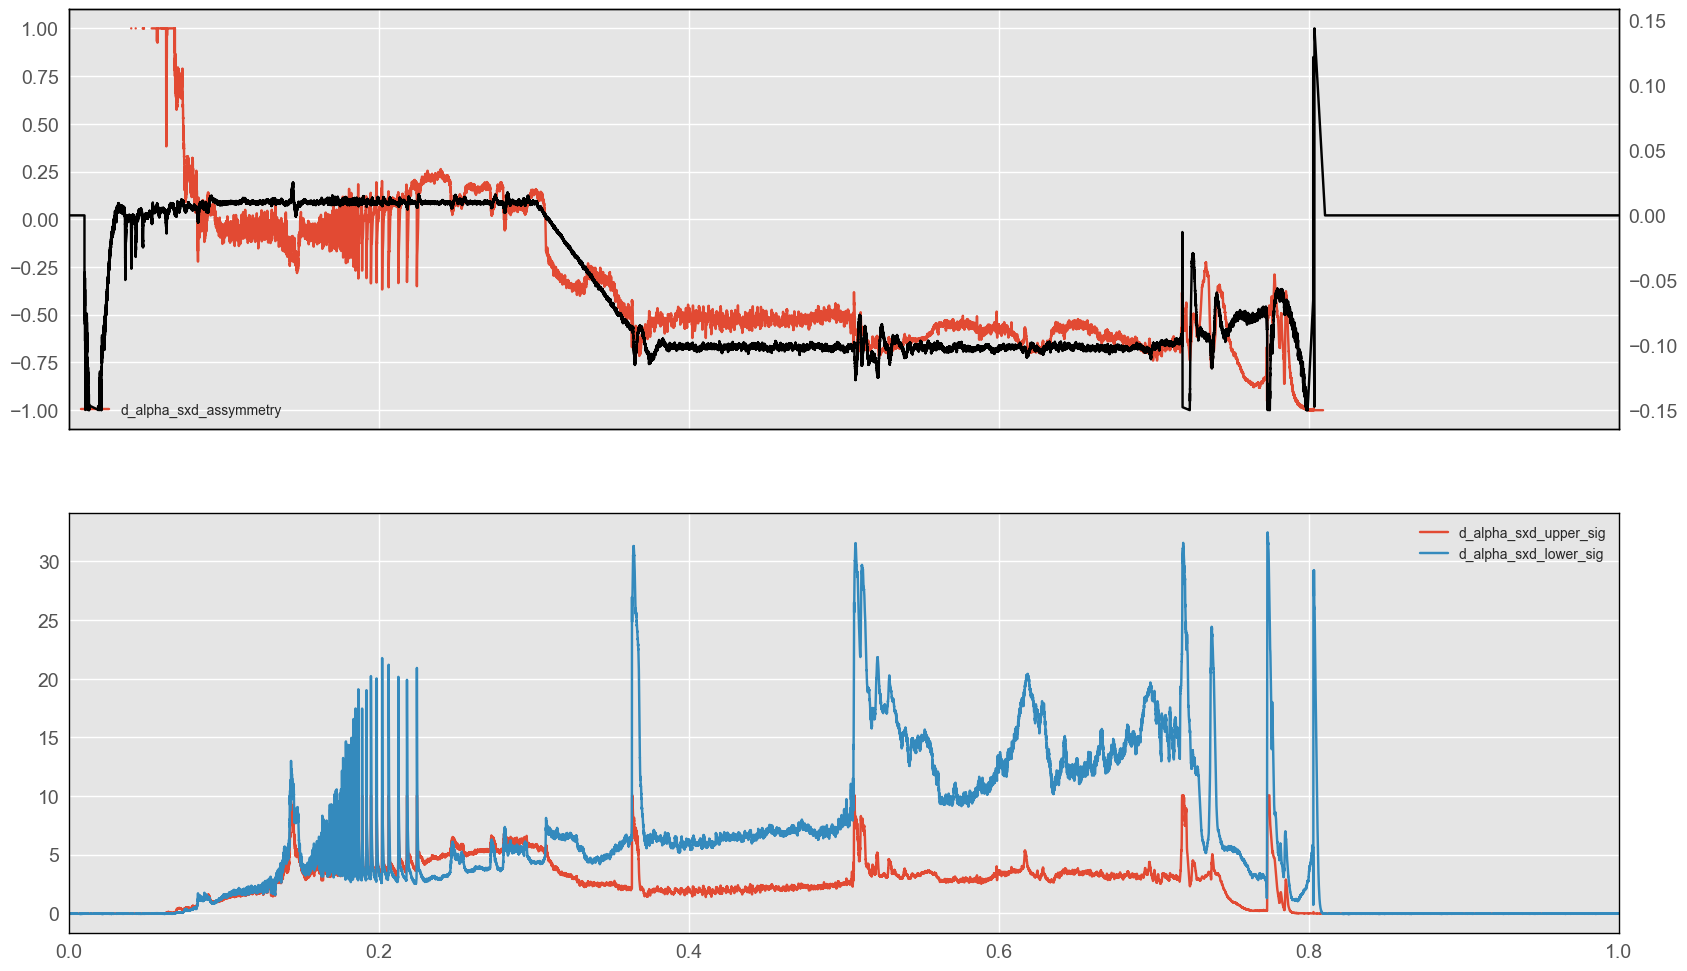

In [6]:
shot_number = 49259

cal_fac = 4


sxd_calibration(shot_number, cal_fac = cal_fac)

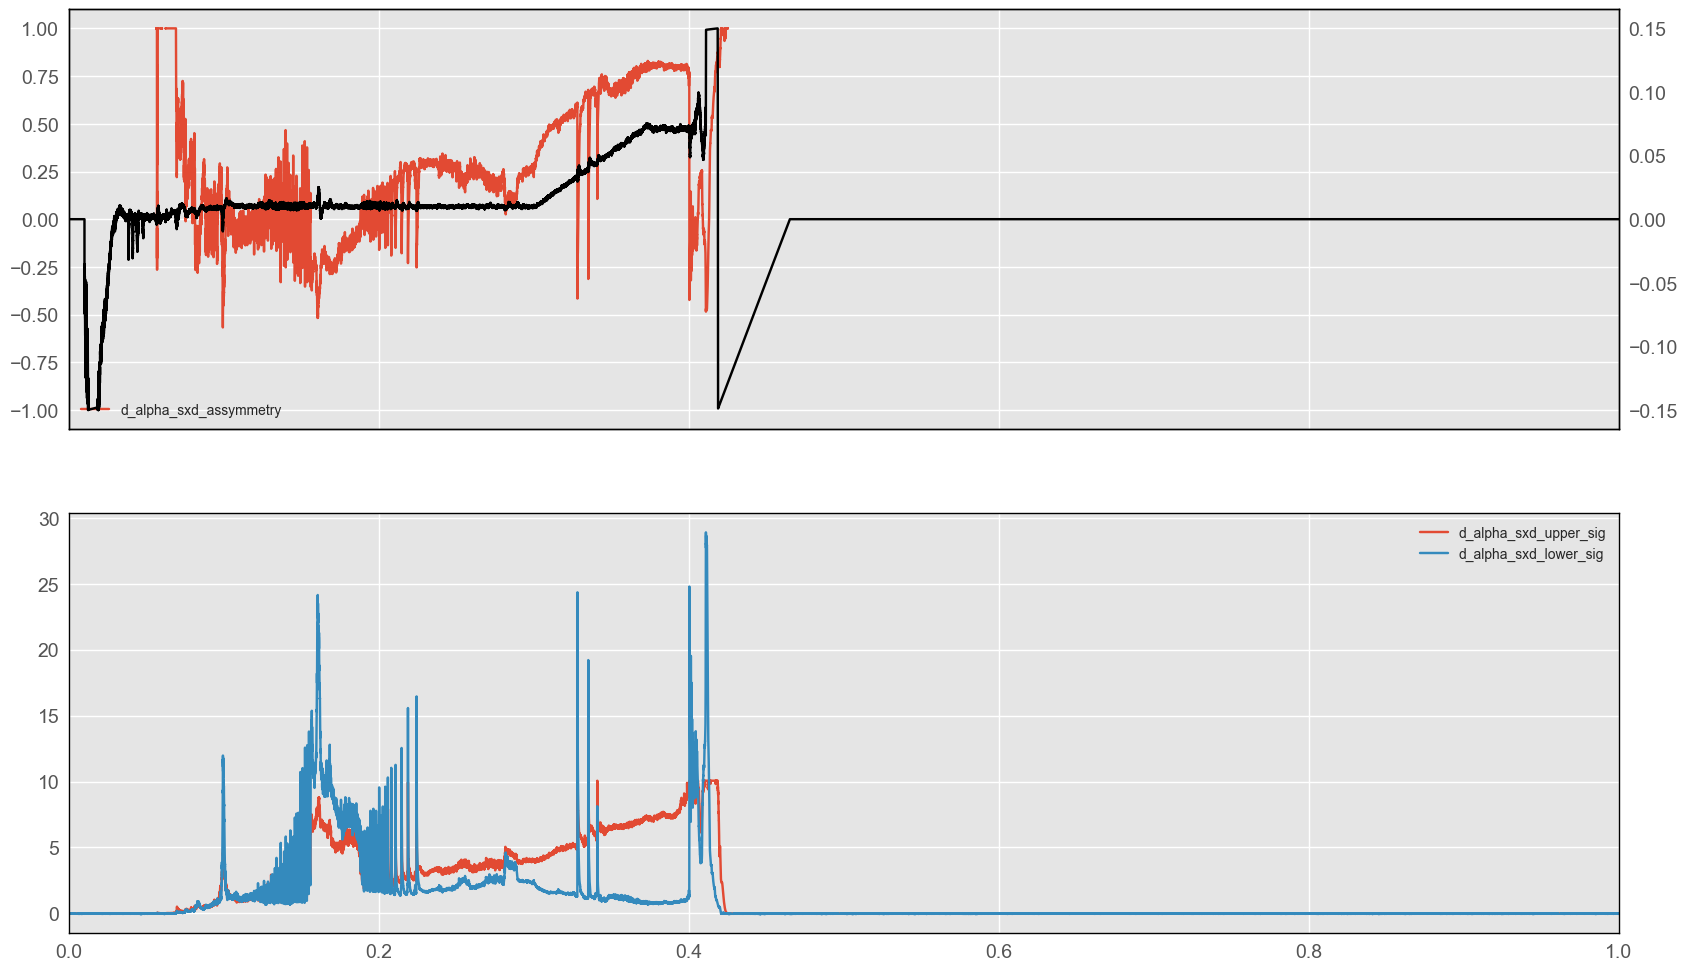

In [7]:
shot_number = 49262

cal_fac = 4


sxd_calibration(shot_number, cal_fac = cal_fac)

# Implementing a low pass filter

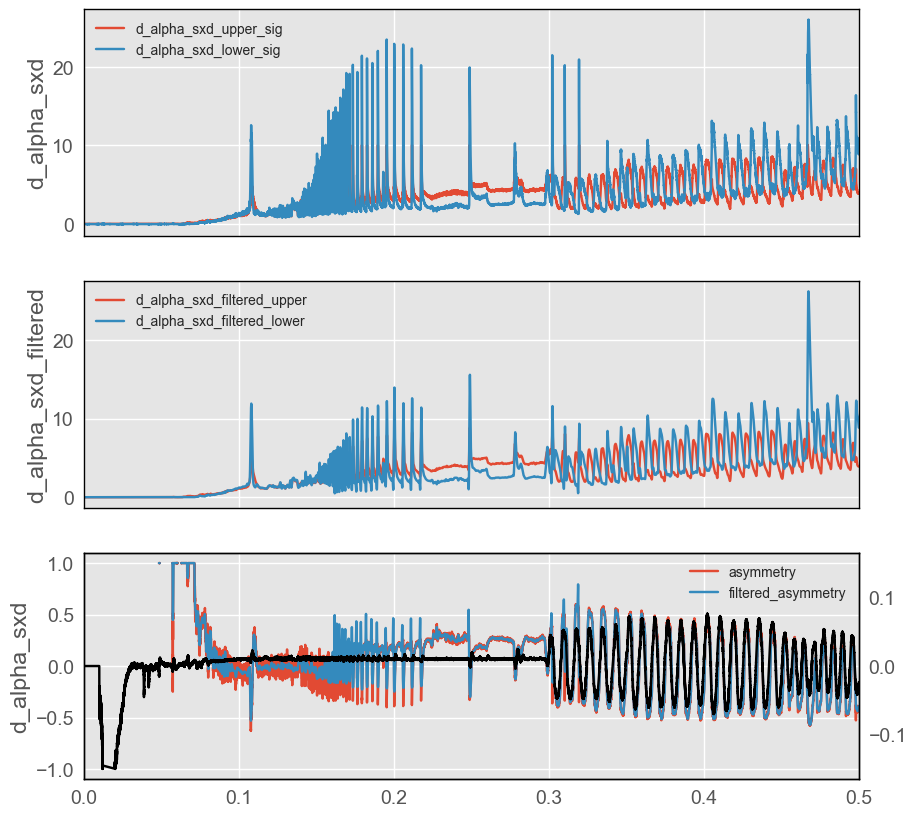

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Extract signals

shot_number = 49261

cal_fac = 4

d_alpha_sxd, d_alpha_sxd_time = d_alpha_divertor_asymmetry(shot_number, 'SXD', output_time=True, calibrate = cal_fac)
d_alpha_sxd_upper_sig, d_alpha_sxd_lower_sig, d_alpha_sig_time = d_alpha_signal(shot_number, 'SXD', output_time=True, calibrate = cal_fac)
mag_z, mag_time = magnetic_axis_zc(shot_number, output_time=True, trim=True)

def low_pass_filter(data, cutoff_frequency, sampling_rate, order=4):
    """
    Apply a low-pass filter to the given data.

    Parameters:
    - data: array-like, the input signal to be filtered
    - cutoff_frequency: float, the cutoff frequency of the filter
    - sampling_rate: float, the sampling rate of the data
    - order: int, optional, the order of the filter (default is 4)

    Returns:
    - filtered_data: array-like, the filtered signal
    """
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Filter the signals
cutoff_frequency = 1000  # Hz
sampling_rate = 100000  # Hz
order = 4
d_alpha_sxd_filtered_upper = low_pass_filter(d_alpha_sxd_upper_sig, cutoff_frequency, sampling_rate, order)
d_alpha_sxd_filtered_lower = low_pass_filter(d_alpha_sxd_lower_sig, cutoff_frequency, sampling_rate, order)

# floor filtered signals to zero
d_alpha_sxd_filtered_upper[d_alpha_sxd_filtered_upper < 0] = 0
d_alpha_sxd_filtered_lower[d_alpha_sxd_filtered_lower < 0] = 0

filtered_asymmetry = (d_alpha_sxd_filtered_upper - d_alpha_sxd_filtered_lower) / (d_alpha_sxd_filtered_upper + d_alpha_sxd_filtered_lower)

# Plot the signals
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(d_alpha_sig_time, d_alpha_sxd_upper_sig, label='d_alpha_sxd_upper_sig')
ax[0].plot(d_alpha_sig_time, d_alpha_sxd_lower_sig, label='d_alpha_sxd_lower_sig')
ax[0].set_ylabel('d_alpha_sxd')

ax[1].plot(d_alpha_sig_time, d_alpha_sxd_filtered_upper, label='d_alpha_sxd_filtered_upper')
ax[1].plot(d_alpha_sig_time, d_alpha_sxd_filtered_lower, label='d_alpha_sxd_filtered_lower')
ax[1].set_ylabel('d_alpha_sxd_filtered')

ax[2].plot(d_alpha_sxd_time, d_alpha_sxd, label='asymmetry')
ax[2].set_ylabel('d_alpha_sxd')

ax[2].plot(d_alpha_sig_time, filtered_asymmetry, label='filtered_asymmetry')

ax_right = ax[2].twinx()

ax_right.plot(mag_time, mag_z, label='mag_z', color='black')

ax_right.grid(False)

for axesx in ax:
    axesx.set_xbound(0, 0.5)
    axesx.legend()



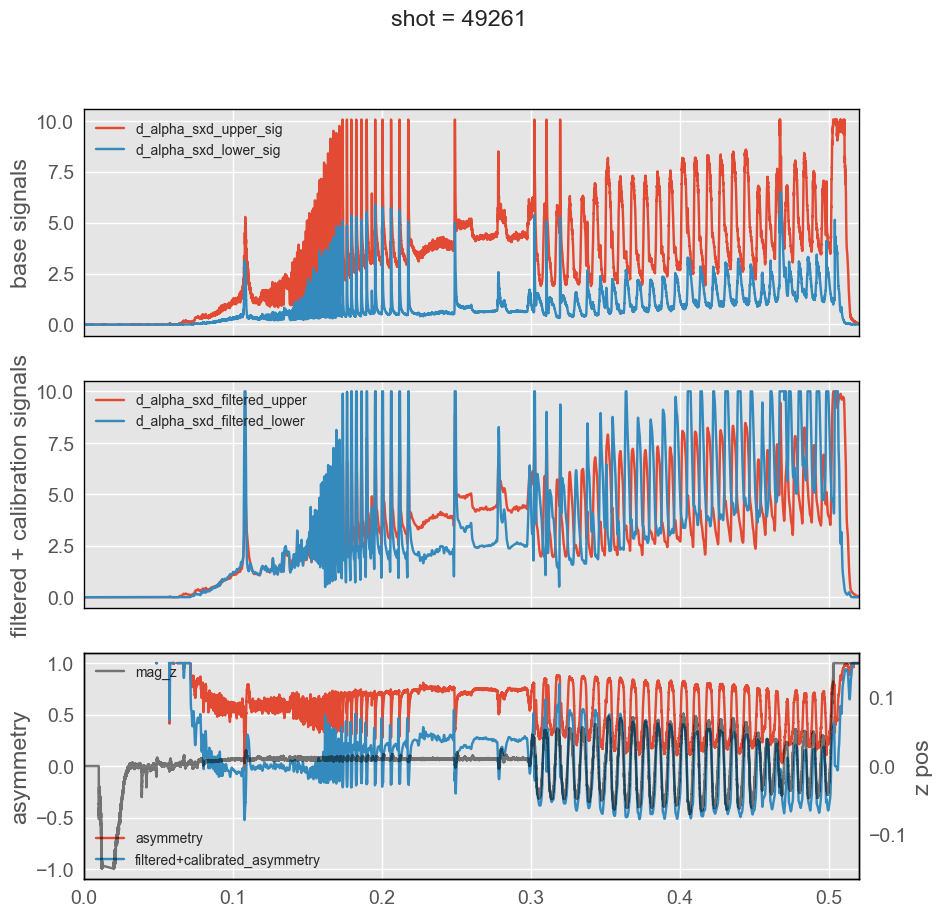

In [21]:
shot_number =49059 
shot_number = 49261

cal_fac = 4

d_alpha_sxd, d_alpha_sxd_time = d_alpha_divertor_asymmetry(shot_number, 'SXD', output_time=True)
d_alpha_sxd_upper_sig_uncal, d_alpha_sxd_lower_sig_uncal, d_alpha_sig_time = d_alpha_signal(shot_number, 'SXD', output_time=True)
d_alpha_sxd_upper_sig, d_alpha_sxd_lower_sig, d_alpha_sig_time = d_alpha_signal(shot_number, 'SXD', output_time=True, calibrate = cal_fac)
mag_z, mag_time = magnetic_axis_zc(shot_number, output_time=True, trim=True)
mag_efit, mag_time_efit = magnetic_axis_efit(shot_number, output_time=True)

def low_pass_filter(data, cutoff_frequency, sampling_rate, order=4):
    """
    Apply a low-pass filter to the given data.

    Parameters:
    - data: array-like, the input signal to be filtered
    - cutoff_frequency: float, the cutoff frequency of the filter
    - sampling_rate: float, the sampling rate of the data
    - order: int, optional, the order of the filter (default is 4)

    Returns:
    - filtered_data: array-like, the filtered signal
    """
    nyquist_frequency = 0.5 * sampling_rate
    normal_cutoff = cutoff_frequency / nyquist_frequency
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Filter the signals
cutoff_frequency = 1000  # Hz
sampling_rate = 100000  # Hz
order = 4
d_alpha_sxd_filtered_upper = low_pass_filter(d_alpha_sxd_upper_sig, cutoff_frequency, sampling_rate, order)
d_alpha_sxd_filtered_lower = low_pass_filter(d_alpha_sxd_lower_sig, cutoff_frequency, sampling_rate, order)

# floor filtered signals to zero
d_alpha_sxd_filtered_upper[d_alpha_sxd_filtered_upper < 0] = 0
d_alpha_sxd_filtered_lower[d_alpha_sxd_filtered_lower < 0] = 0

# ceiling filtered signals to 10
d_alpha_sxd_filtered_upper[d_alpha_sxd_filtered_upper > 10] = 10
d_alpha_sxd_filtered_lower[d_alpha_sxd_filtered_lower > 10] = 10

filtered_asymmetry = (d_alpha_sxd_filtered_upper - d_alpha_sxd_filtered_lower) / (d_alpha_sxd_filtered_upper + d_alpha_sxd_filtered_lower)

# Plot the signals
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
ax[0].plot(d_alpha_sig_time, d_alpha_sxd_upper_sig_uncal, label='d_alpha_sxd_upper_sig')
ax[0].plot(d_alpha_sig_time, d_alpha_sxd_lower_sig_uncal, label='d_alpha_sxd_lower_sig')
ax[0].set_ylabel('base signals')

ax[1].plot(d_alpha_sig_time, d_alpha_sxd_filtered_upper, label='d_alpha_sxd_filtered_upper')
ax[1].plot(d_alpha_sig_time, d_alpha_sxd_filtered_lower, label='d_alpha_sxd_filtered_lower')
ax[1].set_ylabel('filtered + calibration signals')

ax[2].plot(d_alpha_sxd_time, d_alpha_sxd, label='asymmetry')
ax[2].set_ylabel('asymmetry')


ax[2].plot(d_alpha_sig_time, filtered_asymmetry, label='filtered+calibrated_asymmetry')

ax_right = ax[2].twinx()

ax_right.plot(mag_time, mag_z, label='mag_z', color='black', alpha = 0.5)
ax_right.set_ylabel('z pos')
ax_right.grid(False)
ax_right.legend()

fig.suptitle(f'shot = {shot_number}')
for axesx in ax:
    axesx.set_xbound(0, mag_time_efit[-1])
    axesx.legend()

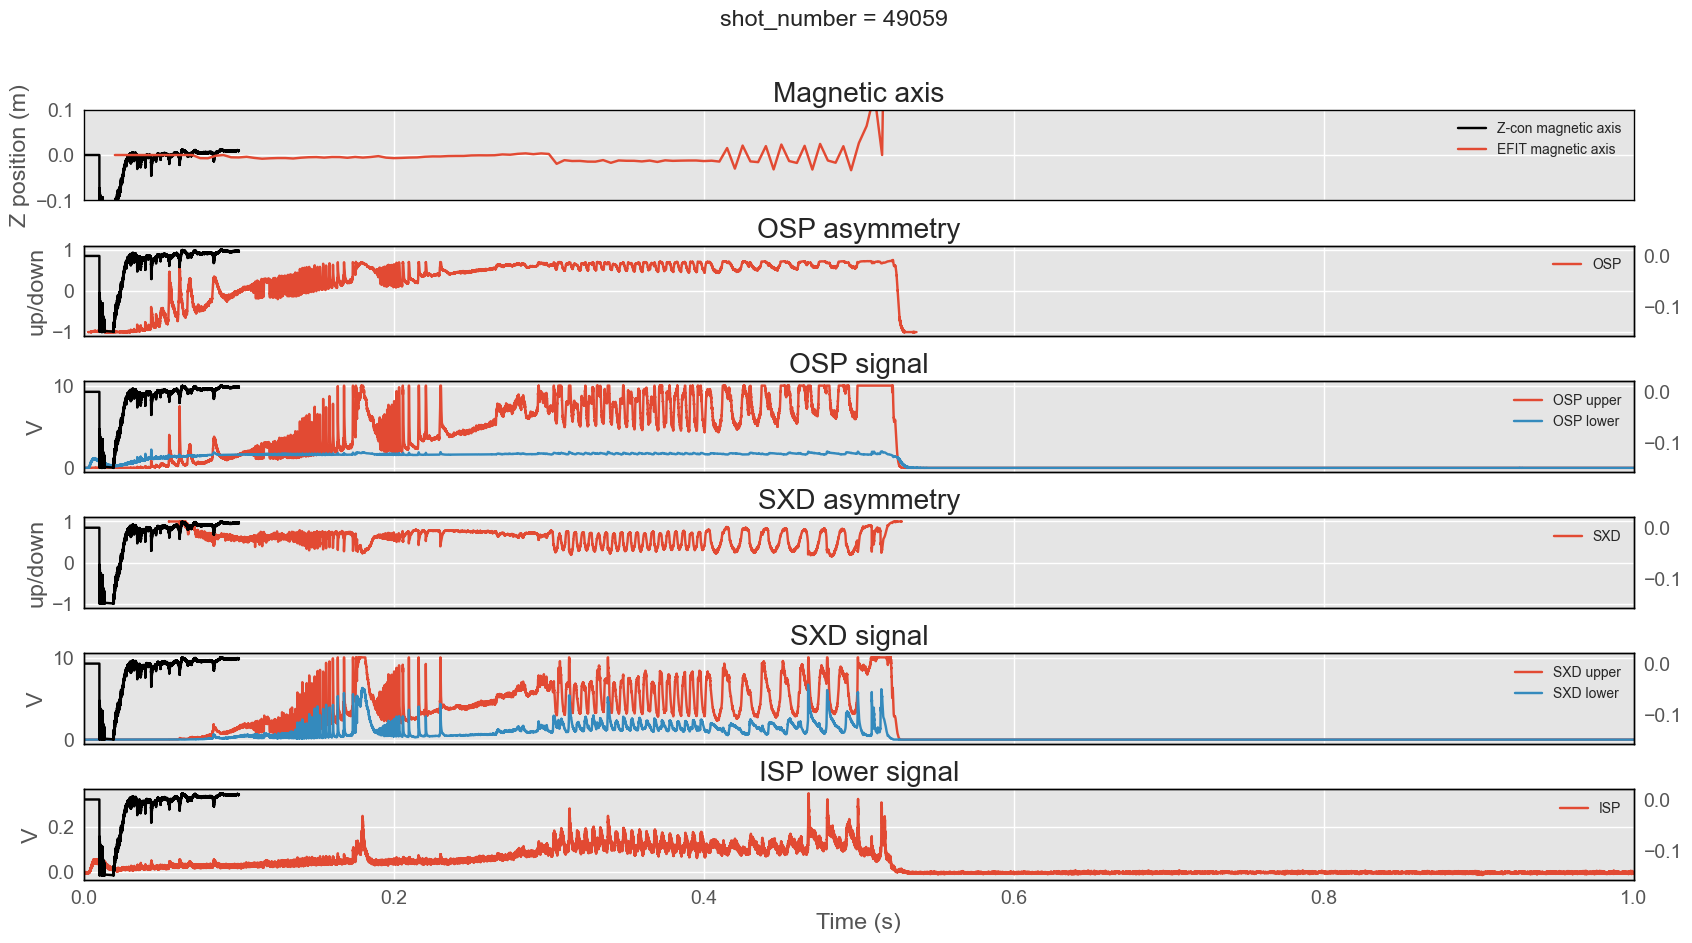

In [10]:
shot_number =49059 
compare_d_alpha(shot_number, f'shot_number = {shot_number}')

In [19]:
def compare_d_alpha_test(shot_number, title):
    # Gather data for magnetic axes and divertor asymmetry
    mag_z, mag_time = magnetic_axis_zc(shot_number, output_time=True, trim=True)
    mag_efit, mag_time_efit = magnetic_axis_efit(shot_number, output_time=True)
    d_alpha_osp, d_alpha_osp_time = d_alpha_divertor_asymmetry(shot_number, 'OSP', output_time=True)
    # d_alpha_isp, d_alpha_isp_time = d_alpha_divertor_asymmetry(shot_number, 'ISP', output_time=True)
    d_alpha_sxd, d_alpha_sxd_time = d_alpha_divertor_asymmetry(shot_number, 'SXD', output_time=True)
    d_alpha_osp_upper_sig, d_alpha_osp_lower_sig, d_alpha_osp_upper_time = d_alpha_signal(shot_number, 'OSP', output_time=True, normalisation=False)
    d_alpha_isp_lower_sig, d_alpha_isp_upper_time = d_alpha_signal(shot_number, 'ISP', output_time=True, normalisation=False)
    d_alpha_sxd_upper_sig, d_alpha_sxd_lower_sig, d_alpha_sxd_upper_time = d_alpha_signal(shot_number, 'SXD', output_time=True, normalisation=False)

    # Plotting setup


    fig, axes = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
    fig.subplots_adjust(hspace=0.5)  # Adjust vertical spacing
    fig.suptitle(title)
    # Plot magnetic axis
    axes[0].plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes[0].plot(mag_time_efit, mag_efit, label='EFIT magnetic axis')
    axes[0].set_ylim(-0.10, 0.10)
    axes[0].set_xlim(0, mag_time_efit[-1])
    axes[0].set_ylabel('Z position (m)')
    
    axes[0].set_title('Magnetic axis')
    axes[0].legend(loc='upper right')

    # Plot OSP asymmetry and magnetic axis
    axes[1].plot(d_alpha_osp_time, d_alpha_osp, label='OSP')
    axes12 = axes[1].twinx()
    axes12.plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes12.grid(False)
    axes[1].set_ylabel('up/down')
    axes[1].set_title('OSP asymmetry')
    axes[1].legend(loc='upper right')

    # Plot OSP signal
    axes[2].plot(d_alpha_osp_upper_time, d_alpha_osp_upper_sig, label='OSP upper')
    axes[2].plot(d_alpha_osp_upper_time, d_alpha_osp_lower_sig, label='OSP lower')
    axes22 = axes[2].twinx()
    axes22.plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes22.grid(False)
    axes[2].set_ylabel('V')
    axes[2].set_title('OSP signal')
    axes[2].legend(loc='upper right')

    # Plot SXD asymmetry and magnetic axis
    axes[3].plot(d_alpha_sxd_time, d_alpha_sxd, label='SXD')
    axes32 = axes[3].twinx()
    axes32.plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes32.grid(False)
    axes[3].set_ylabel('up/down')
    axes[3].set_title('SXD asymmetry')
    axes[3].legend(loc='upper right')

    # Plot SXD signal
    axes[4].plot(d_alpha_sxd_upper_time, d_alpha_sxd_upper_sig, label='SXD upper')
    axes[4].plot(d_alpha_sxd_upper_time, d_alpha_sxd_lower_sig, label='SXD lower')
    axes42 = axes[4].twinx()
    axes42.plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes42.grid(False)
    axes[4].set_ylabel('V')
    axes[4].set_title('SXD signal')
    axes[4].legend(loc='upper right')

    # Plot ISP
    axes[5].plot(d_alpha_isp_upper_time, d_alpha_isp_lower_sig, label='ISP')
    axes52 = axes[5].twinx()
    axes52.plot(mag_time, mag_z, label='Z-con magnetic axis', color='black')
    axes52.grid(False)
    axes[5].set_ylabel('V')
    axes[5].set_xlabel('Time (s)')
    axes[5].set_title('ISP lower signal')
    axes[5].legend(loc='upper right')

    plt.show()


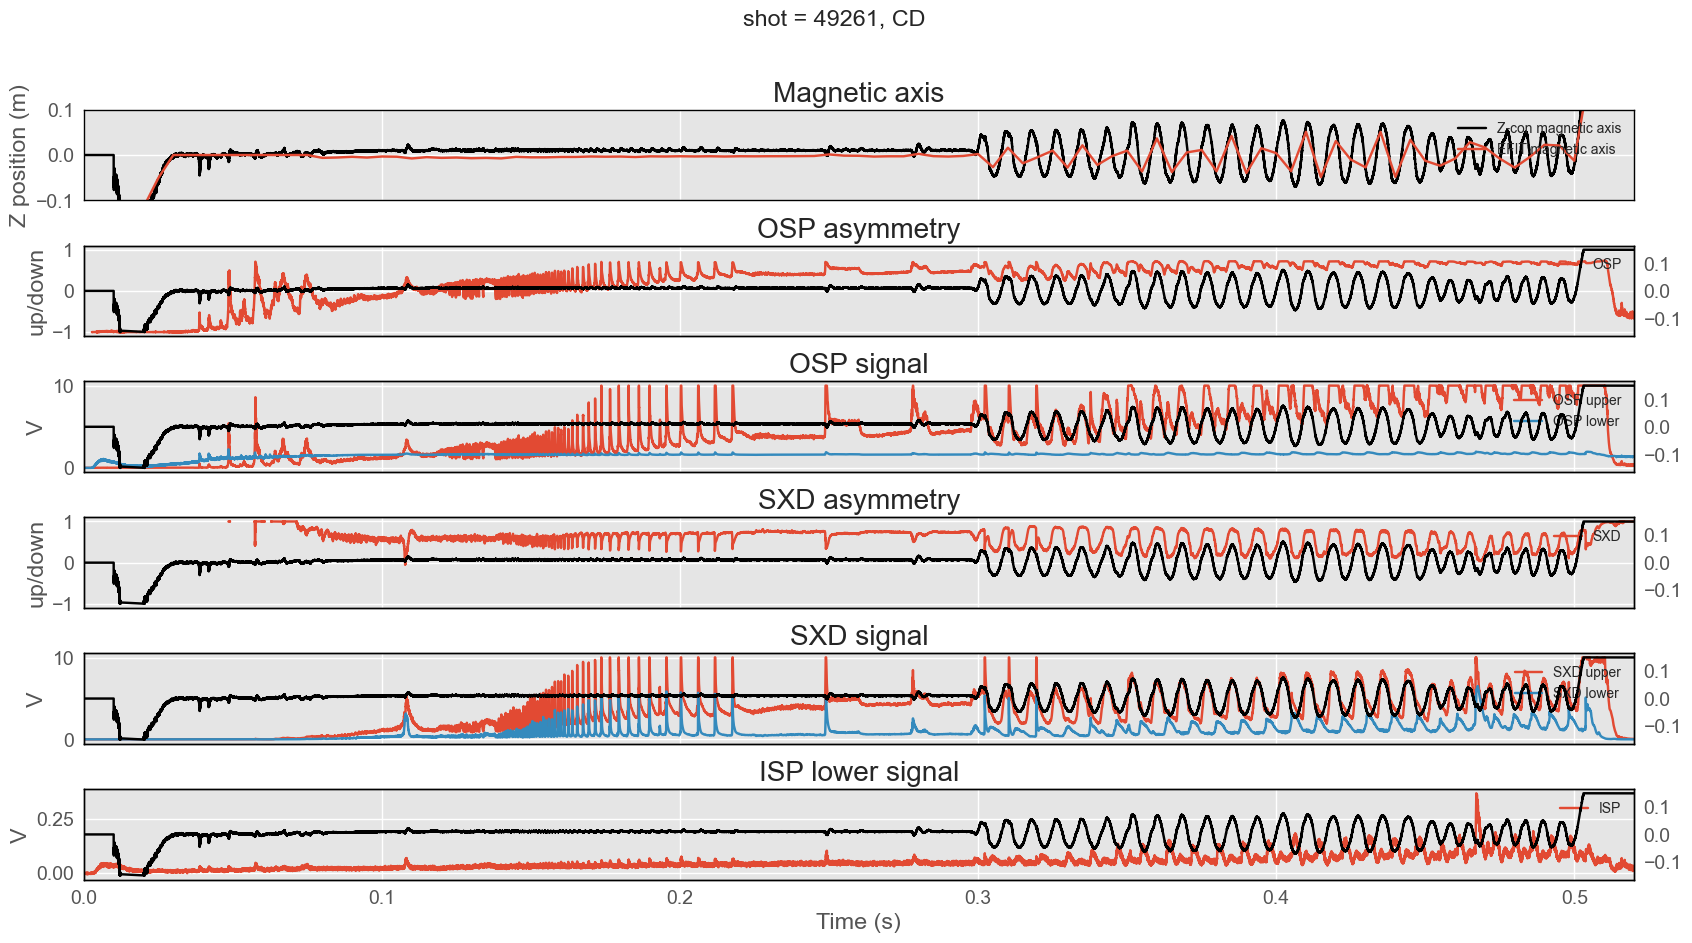

In [24]:
shot_number = 49261
compare_d_alpha_test(shot_number, f'shot = {shot_number}, CD, 2B')

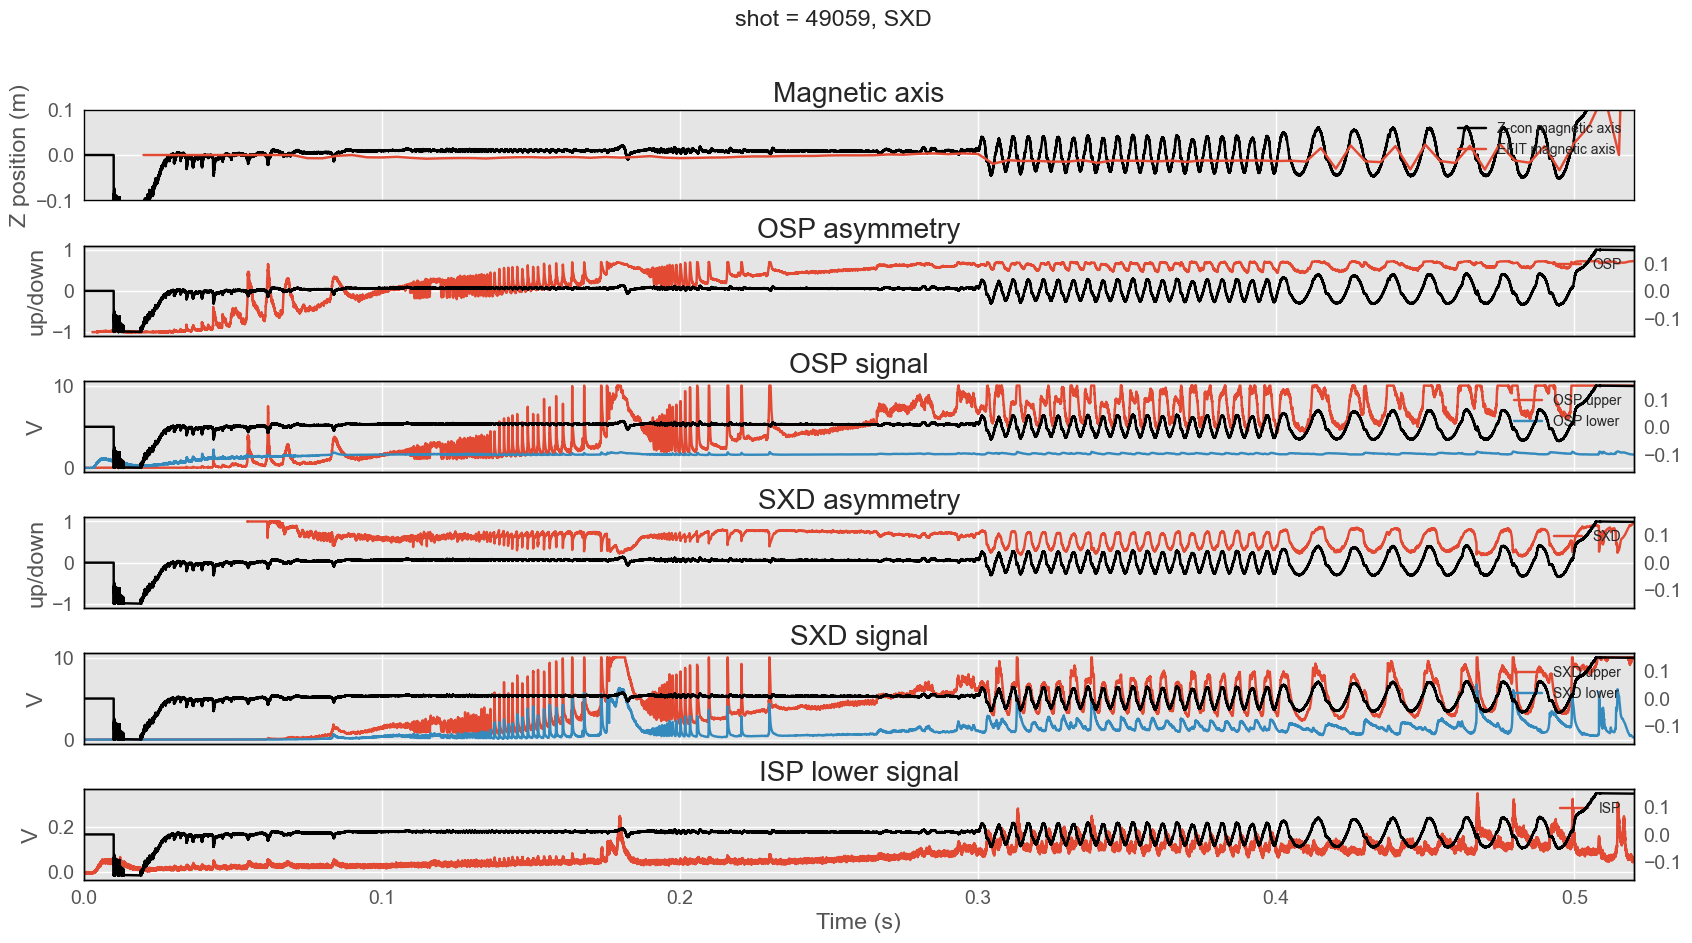

In [25]:
shot_number = 49059
compare_d_alpha_test(shot_number, f'shot = {shot_number}, SXD , 2B')